In [ ]:
from keras_segmentation.models.all_models import model_from_name
import six
from keras_segmentation.data_utils.data_loader import image_segmentation_generator, \
    verify_segmentation_dataset
from keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint

### Use the below if you are training from scratch

In [ ]:
from keras_segmentation.models.unet import vgg_unet

model = vgg_unet(n_classes=50 ,  input_height=320, input_width=640  )

In [ ]:
model7.summary()

In [ ]:
#model = model.load_weights('divam_ss_base.03.h5')

In [ ]:
if isinstance(model, six.string_types):
    # create the model from the name
    assert (n_classes is not None), "Please provide the n_classes"
    if (input_height is not None) and (input_width is not None):
        model = model_from_name[model](
            n_classes, input_height=input_height, input_width=input_width)
    else:
        model = model_from_name[model](n_classes)

In [ ]:
#model = model.load_weights('divam_ss_base.03.h5')

In [ ]:
n_classes = model.n_classes
input_height = model.input_height
input_width = model.input_width
output_height = model.output_height
output_width = model.output_width

In [ ]:
n_classes = 50
input_height = 320
input_width = 640
output_height = 160
output_width = 320

In [ ]:
loss_k = 'categorical_crossentropy'
model.compile(loss=loss_k,
                      optimizer='adam',
                      metrics=['accuracy'])

### Execute this if you are planning to predict or train the network

In [ ]:
train_images="dataset1/images_prepped_train/"
train_annotations="dataset1/annotations_prepped_train/"
#input_height=None
#input_width=None
#n_classes=None
verify_dataset=True
checkpoints_path=None
epochs=1
batch_size=2
validate=False
val_images=None
val_annotations=None
val_batch_size=2
auto_resume_checkpoint=False
load_weights=None
steps_per_epoch=512
val_steps_per_epoch=512
gen_use_multiprocessing=False
ignore_zero_class=False
optimizer_name='adam'
do_augment=False
augmentation_name="aug_all",
callbacks=None
custom_augmentation=None
other_inputs_paths=None
preprocessing=None
read_image_type=1

In [ ]:
train_gen = image_segmentation_generator(
        train_images, train_annotations,  batch_size,  n_classes,
        input_height, input_width, output_height, output_width,
        do_augment=do_augment, augmentation_name=augmentation_name,
        custom_augmentation=custom_augmentation, other_inputs_paths=other_inputs_paths,
        preprocessing=preprocessing, read_image_type=read_image_type)

In [ ]:
checkpoints_path = 'divam_ss_base_test'
default_callback = ModelCheckpoint(
            filepath=checkpoints_path + ".{epoch:02d}.h5",
            save_weights_only=False,
            verbose=True
        )

In [ ]:
initial_epoch=0
model.fit(train_gen, steps_per_epoch=steps_per_epoch,
                  epochs=epochs, callbacks=default_callback, initial_epoch=initial_epoch)

In [ ]:
out = model.predict_segmentation(
    inp="dataset1/images_prepped_test/0016E5_07965.png",
    out_fname="/tmp/out.png"
)

In [ ]:
model.save('dg_base_ep1.h5')

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(out)

In [ ]:
model2=model.load_model('dg_base_ep1.h5')

In [ ]:
model2.summary()

In [ ]:
def get_image_array(image_input,
                    width, height,
                    imgNorm="sub_mean", ordering='channels_first', read_image_type=1):
    """ Load image array from input """

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, six.string_types):
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_image_array: path {0} doesn't exist"
                                  .format(image_input))
        img = cv2.imread(image_input, read_image_type)
    else:
        raise DataLoaderError("get_image_array: Can't process input type {0}"
                              .format(str(type(image_input))))

    if imgNorm == "sub_and_divide":
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    elif imgNorm == "sub_mean":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = np.atleast_3d(img)

        means = [103.939, 116.779, 123.68]

        for i in range(min(img.shape[2], len(means))):
            img[:, :, i] -= means[i]

        img = img[:, :, ::-1]
    elif imgNorm == "divide":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = img/255.0

    if ordering == 'channels_first':
        img = np.rollaxis(img, 2, 0)
    return img

In [ ]:
import numpy as np

IMAGE_ORDERING = "channels_last"
x = get_image_array(inp, input_width, input_height,
                    ordering=IMAGE_ORDERING)

In [ ]:
pr = model7.predict(np.array([x]))[0]
pr = pr.reshape((output_height,  output_width, n_classes)).argmax(axis=2)

In [ ]:
import random

class_colors = [(random.randint(0, 255), random.randint(
    0, 255), random.randint(0, 255)) for _ in range(5000)]

def visualize_segmentation(seg_arr, inp_img=None, n_classes=None,
                           colors=class_colors, class_names=None,
                           overlay_img=False, show_legends=False,
                           prediction_width=None, prediction_height=None):

    if n_classes is None:
        n_classes = np.max(seg_arr)

    seg_img = get_colored_segmentation_image(seg_arr, n_classes, colors=colors)

    if inp_img is not None:
        original_h = inp_img.shape[0]
        original_w = inp_img.shape[1]
        seg_img = cv2.resize(seg_img, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    if (prediction_height is not None) and (prediction_width is not None):
        seg_img = cv2.resize(seg_img, (prediction_width, prediction_height), interpolation=cv2.INTER_NEAREST)
        if inp_img is not None:
            inp_img = cv2.resize(inp_img,
                                 (prediction_width, prediction_height))

    if overlay_img:
        assert inp_img is not None
        seg_img = overlay_seg_image(inp_img, seg_img)

    if show_legends:
        assert class_names is not None
        legend_img = get_legends(class_names, colors=colors)

        seg_img = concat_lenends(seg_img, legend_img)

    return seg_img

def get_colored_segmentation_image(seg_arr, n_classes, colors=class_colors):
    output_height = seg_arr.shape[0]
    output_width = seg_arr.shape[1]

    seg_img = np.zeros((output_height, output_width, 3))

    for c in range(n_classes):
        seg_arr_c = seg_arr[:, :] == c
        seg_img[:, :, 0] += ((seg_arr_c)*(colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg_arr_c)*(colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg_arr_c)*(colors[c][2])).astype('uint8')

    return seg_img

In [ ]:
overlay_img=False
show_legends=False
class_names=None
prediction_width=None
prediction_height=None

seg_img = visualize_segmentation(pr, inp, n_classes=n_classes,
                                 colors=class_colors, overlay_img=overlay_img,
                                 show_legends=show_legends,
                                 class_names=class_names,
                                 prediction_width=prediction_width,
                                 prediction_height=prediction_height)

In [ ]:
while(True):
    cv2.imshow('im', seg_img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(seg_img)

### Use the below if you are loading the model

In [ ]:
from keras_segmentation.models.unet import vgg_unet
from tensorflow.keras.models import load_model

model = vgg_unet(n_classes=50 ,  input_height=320, input_width=640  )
#model7=load_model('./striped_divam_ss_pruned.01.h5')
model8=load_model('./divam_ss_base_test.01.h5')
print('done')


In [ ]:
import cv2
inp = cv2.imread("dataset1/images_prepped_test/0016E5_07965.png",1)

### Pruning the model

In [ ]:
import tensorflow_model_optimization as tfmot 
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule as pruning_sched
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

In [ ]:
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=1000)
}

#'''

model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model6, **pruning_params)

In [ ]:
p_checkpoints_path = 'divam_ss_pruned'
p_checkpoint = ModelCheckpoint(filepath=p_checkpoints_path + ".{epoch:02d}.h5",save_weights_only=False,
                              verbose=True)

In [ ]:
log_dir = './pruning_logs'
p_callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    # Log sparsity and other metrics in Tensorboard.
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir),p_checkpoint]

In [ ]:
model_for_pruning.compile(loss=loss_k,
                      optimizer='adam',
                      metrics=['accuracy'])

In [ ]:
initial_epoch=0
model_for_pruning.fit(train_gen, steps_per_epoch=steps_per_epoch,
                  epochs=1, callbacks=p_callbacks, initial_epoch=initial_epoch)

In [ ]:
pr = model_for_pruning.predict(np.array([x]))[0]
pr = pr.reshape((output_height,  output_width, n_classes)).argmax(axis=2)

### Strip pruning to remove the pruning layer names to the default

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.save('striped_divam_ss_pruned.01.h5', include_optimizer=True)

### End to end inference from a loaded model

In [1]:

from keras_segmentation.models.unet import vgg_unet
from tensorflow.keras.models import load_model

model = vgg_unet(n_classes=50 ,  input_height=320, input_width=640  )
#model7=load_model('./striped_divam_ss_pruned.01.h5')
model9=load_model('./divam_ss_base_test.01.h5')
print('done')


done


In [2]:
import cv2
inp = cv2.imread("dataset1/images_prepped_test/0016E5_07965.png",1)

In [3]:
n_classes = 50
input_height = 320
input_width = 640
output_height = 160
output_width = 320

In [4]:
def get_image_array(image_input,
                    width, height,
                    imgNorm="sub_mean", ordering='channels_first', read_image_type=1):
    """ Load image array from input """

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, six.string_types):
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_image_array: path {0} doesn't exist"
                                  .format(image_input))
        img = cv2.imread(image_input, read_image_type)
    else:
        raise DataLoaderError("get_image_array: Can't process input type {0}"
                              .format(str(type(image_input))))

    if imgNorm == "sub_and_divide":
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    elif imgNorm == "sub_mean":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = np.atleast_3d(img)

        means = [103.939, 116.779, 123.68]

        for i in range(min(img.shape[2], len(means))):
            img[:, :, i] -= means[i]

        img = img[:, :, ::-1]
    elif imgNorm == "divide":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = img/255.0

    if ordering == 'channels_first':
        img = np.rollaxis(img, 2, 0)
    return img

In [5]:
import numpy as np

IMAGE_ORDERING = "channels_last"
x = get_image_array(inp, input_width, input_height,
                    ordering=IMAGE_ORDERING)

In [6]:
pr = model9.predict(np.array([x]))[0]
pr = pr.reshape((output_height,  output_width, n_classes)).argmax(axis=2)

In [7]:
import random

class_colors = [(random.randint(0, 255), random.randint(
    0, 255), random.randint(0, 255)) for _ in range(5000)]

def visualize_segmentation(seg_arr, inp_img=None, n_classes=None,
                           colors=class_colors, class_names=None,
                           overlay_img=False, show_legends=False,
                           prediction_width=None, prediction_height=None):

    if n_classes is None:
        n_classes = np.max(seg_arr)

    seg_img = get_colored_segmentation_image(seg_arr, n_classes, colors=colors)

    if inp_img is not None:
        original_h = inp_img.shape[0]
        original_w = inp_img.shape[1]
        seg_img = cv2.resize(seg_img, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    if (prediction_height is not None) and (prediction_width is not None):
        seg_img = cv2.resize(seg_img, (prediction_width, prediction_height), interpolation=cv2.INTER_NEAREST)
        if inp_img is not None:
            inp_img = cv2.resize(inp_img,
                                 (prediction_width, prediction_height))

    if overlay_img:
        assert inp_img is not None
        seg_img = overlay_seg_image(inp_img, seg_img)

    if show_legends:
        assert class_names is not None
        legend_img = get_legends(class_names, colors=colors)

        seg_img = concat_lenends(seg_img, legend_img)

    return seg_img

def get_colored_segmentation_image(seg_arr, n_classes, colors=class_colors):
    output_height = seg_arr.shape[0]
    output_width = seg_arr.shape[1]

    seg_img = np.zeros((output_height, output_width, 3))

    for c in range(n_classes):
        seg_arr_c = seg_arr[:, :] == c
        seg_img[:, :, 0] += ((seg_arr_c)*(colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg_arr_c)*(colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg_arr_c)*(colors[c][2])).astype('uint8')

    return seg_img

In [8]:
overlay_img=False
show_legends=False
class_names=None
prediction_width=None
prediction_height=None

seg_img = visualize_segmentation(pr, inp, n_classes=n_classes,
                                 colors=class_colors, overlay_img=overlay_img,
                                 show_legends=show_legends,
                                 class_names=class_names,
                                 prediction_width=prediction_width,
                                 prediction_height=prediction_height)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


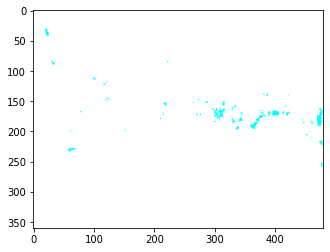

In [9]:
import matplotlib.pyplot as plt
plt.imshow(seg_img)